## 1) Detecting a Marketing Promotion
In the data file named marketing_promo.csv you will find data related to traffic and order activity over a period of several months. During this period a promotion offering free shipping was launched on the website. All visitors were exposed to the promotion and once started it remained active for all of the remaining days in the data you have available.
 1.	Based on the available data, deduce which day the promotion was launched.


Problem appears to be a fairly straight-forward step-change detection problem. Challange will be to remove noise + reoccuring seasonal/temporal patterns.

Start by getting a feel for the data

In [5]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

# figure defaults
from IPython.core.pylabtools import figsize
figsize(14, 7)

plt.rcParams.update({'font.size': 22})
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

In [11]:
df = pd.read_csv("./marketing_promo.csv")

In [12]:
df.describe()

,Day,visits,orders
count,122.000000,122.000000,122.000000
mean,61.500000,3591.819672,30.008197
std,35.362409,582.659903,12.313062
min,1.000000,1840.000000,3.000000
25%,31.250000,3339.750000,22.000000
50%,61.500000,3646.000000,30.000000
75%,91.750000,3865.000000,38.000000
max,122.000000,4885.000000,75.000000


No missing values, no (possibly) crazy outliers ...

In [13]:
df.head()

,Day,visits,orders
0,1,3316,17
1,2,3654,23
2,3,3437,14
3,4,3368,5
4,5,3588,16


Lets get a feel for the time series, let's plot visits (blue) and orders (green) against time:

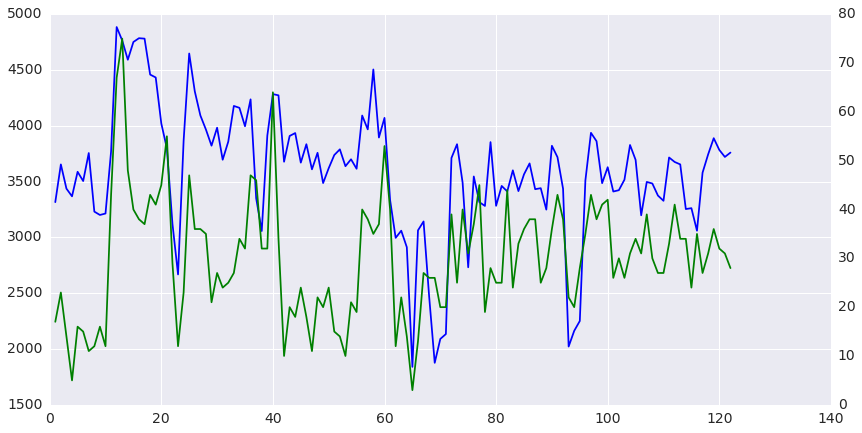

In [18]:
fig, ax = plt.subplots()
plt.plot(df.Day, df.visits, 'b-')
ax2 =ax.twinx()
ax2.plot(df.Day, df.orders, 'g-')
ax2.grid(None)

Relatively messy, possibly some interesting roccuring peaks in the orders figure that a fourier transform or autocorrelation might show up a bit cleaner. 

We would like to see how conversion varies with time (orders/visits).  

In [19]:
df["conversion"] = df.orders/df.visits

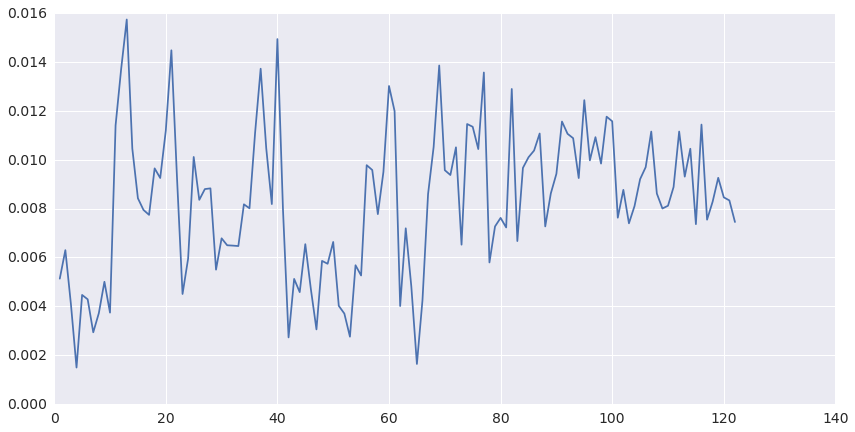

In [20]:
plt.plot(df.Day, df.conversion)

Looks like there might be some seasonal patterns (weekly, monthly)?

Ok, lets have a look at a scatter plot, traffic against order. You would assume the more traffic you have the more orders you would get. 

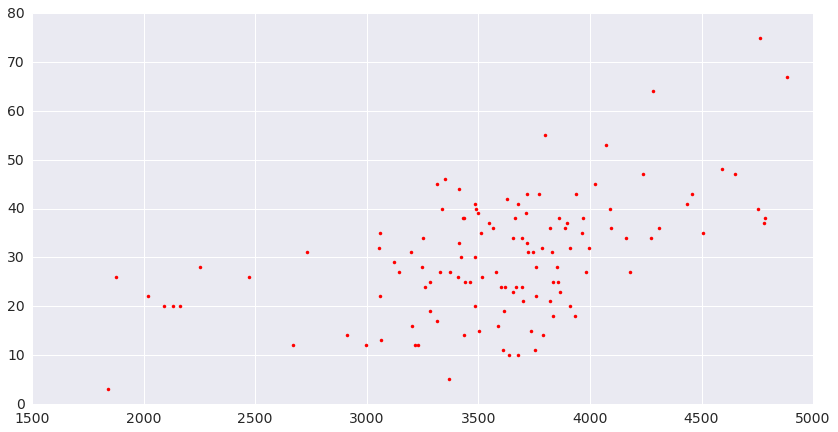

In [17]:
plt.plot(df.visits, df.orders,'r.')

Ok lets do a FFT to get a feel for the signal in freq space

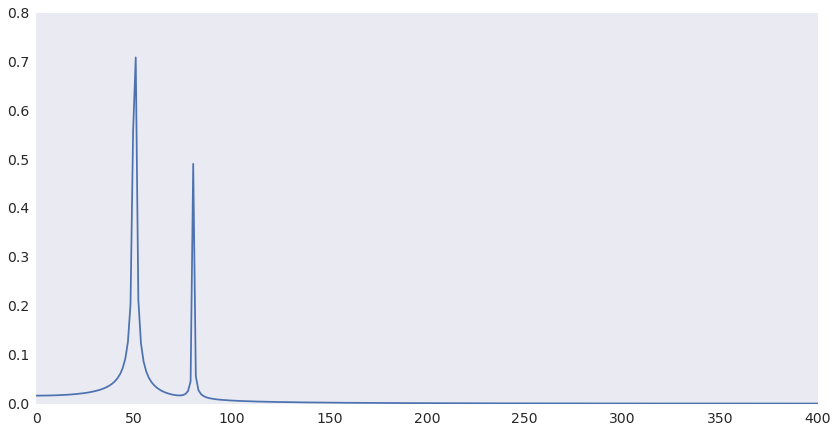

In [31]:
from scipy.fftpack import fft
# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

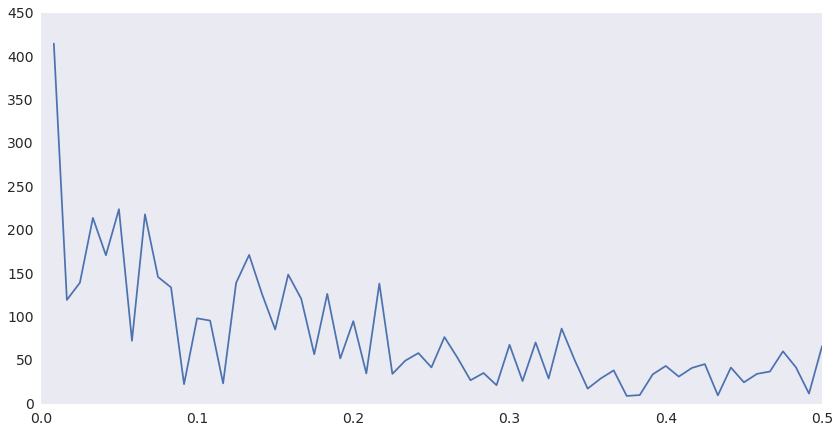

In [48]:
yf = fft(df.visits)
N = len(df.visits)
xf = np.linspace(0.0, 1.0/(2.0), N//2)

plt.plot(xf[1:], 2.0/N * np.abs(yf[1:N//2]))
plt.grid()
plt.show()

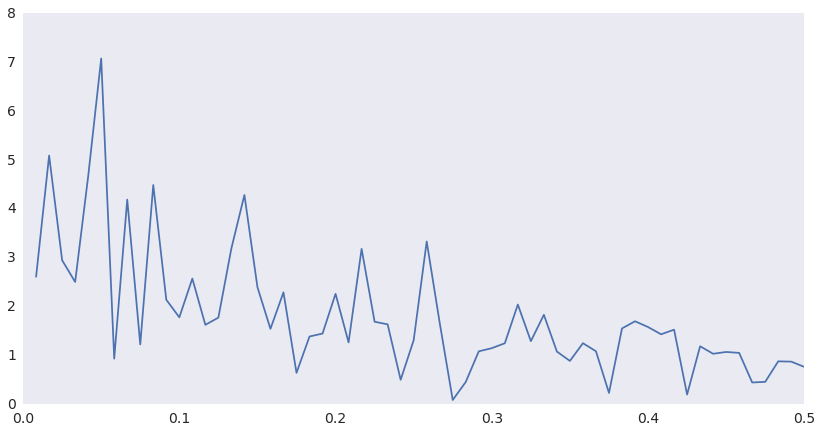

In [47]:
yf = fft(df.orders)
N = len(df.orders)
xf = np.linspace(0.0, 1.0/(2.0), N//2)

plt.plot(xf[1:], 2.0/N * np.abs(yf[1:N//2]))
plt.grid()
plt.show()

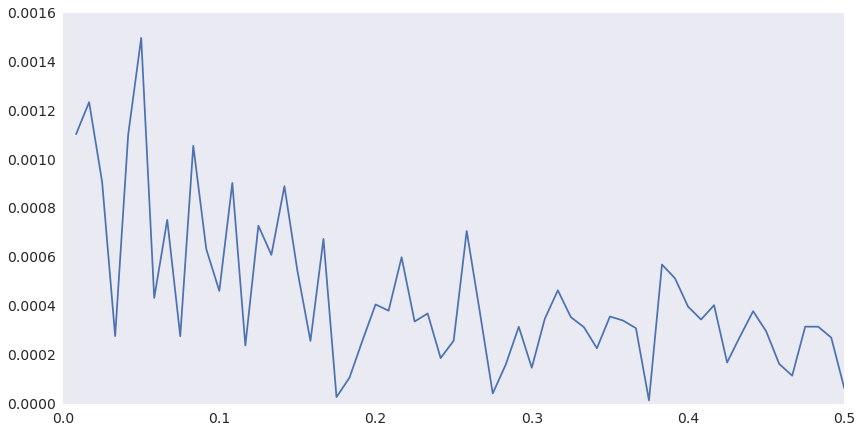

In [46]:
yf = fft(df.conversion)
N = len(df.conversion)
xf = np.linspace(0.0, 1.0/(2.0), N//2)

plt.plot(xf[1:], 2.0/N * np.abs(yf[1:N//2]))
plt.grid()
plt.show()

A few frequencies me might try to filter.

Another thing to look at is run a moving window over the time series and see what affect smoothing noise has

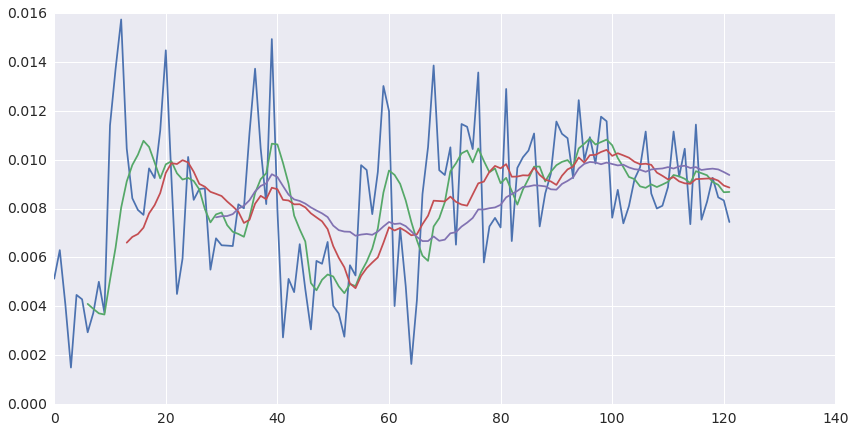

In [55]:
plt.plot(df.conversion)
plt.plot(df.conversion.rolling(7).mean())
plt.plot(df.conversion.rolling(14).mean())
plt.plot(df.conversion.rolling(30).mean())

In [61]:
x = df.Day-len(df.Day)/2

In [63]:
step_fun = 0.5 * (np.sign(x) + 1)

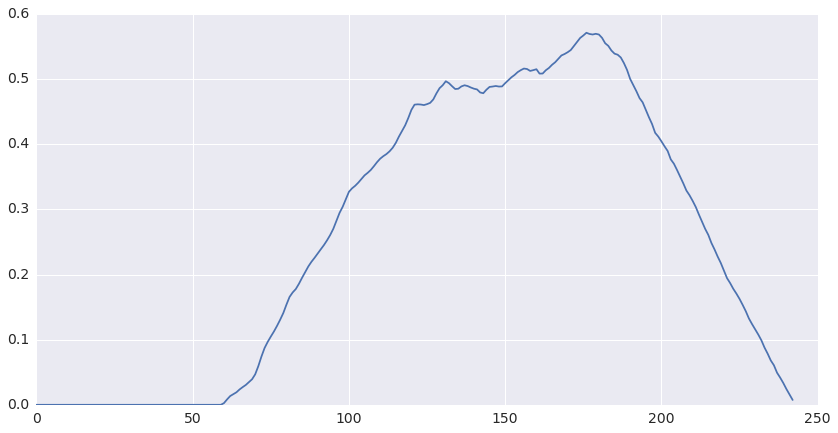

In [66]:
plt.plot(np.convolve(df.conversion, step_fun))

Need to check this... 

### Apply a low-pass filter to signal

In [69]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

1.1574074074074073e-05

In [75]:
fs = 1./(24*60*60)
cutoff = 4./(24*60*60)

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
# T = 5.0*         # seconds
# n = int(T * fs) # total number of samples
# t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
# data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)
data = df.conversion

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

ValueError: Digital filter critical frequencies must be 0 <= Wn <= 1

In [95]:
import numpy as np
 
fc = 0.05  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
b = 0.04  # Transition band, as a fraction of the sampling rate (in (0, 0.5)).
N = int(np.ceil((4 / b)))
if not N % 2: N += 1  # Make sure that N is odd.
n = np.arange(N)
 
# Compute sinc filter.
h = np.sinc(2 * fc * (n - (N - 1) / 2.))
 
# Compute Blackman window.
w = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + \
    0.08 * np.cos(4 * np.pi * n / (N - 1))
 
# Multiply sinc filter with window.
h = h * w
 
# Normalize to get unity gain.
h = h / np.sum(h)

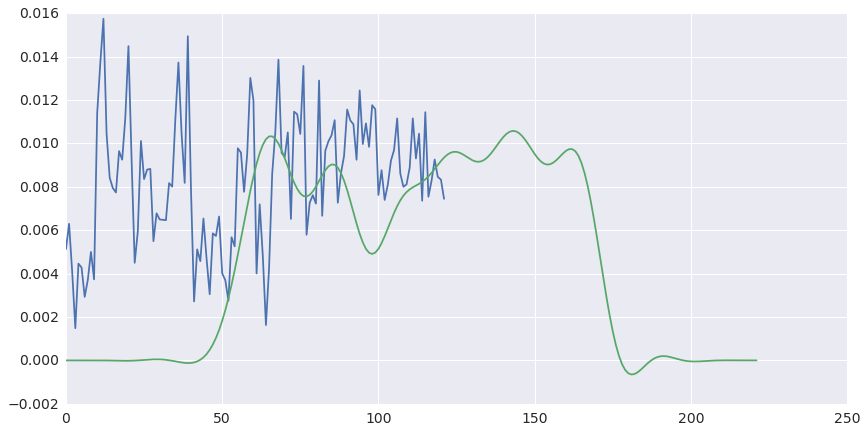

In [96]:
s = np.convolve(df.conversion, h)
plt.plot(df.conversion)
plt.plot(s)

In [89]:
import bayesian_changepoint_detection.offline_changepoint_detection as offcd
from functools import partial

In [90]:
Q, P, Pcp = offcd.offline_changepoint_detection(s[25:-25], partial(offcd.const_prior, l=(len(s[25:-25])+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)

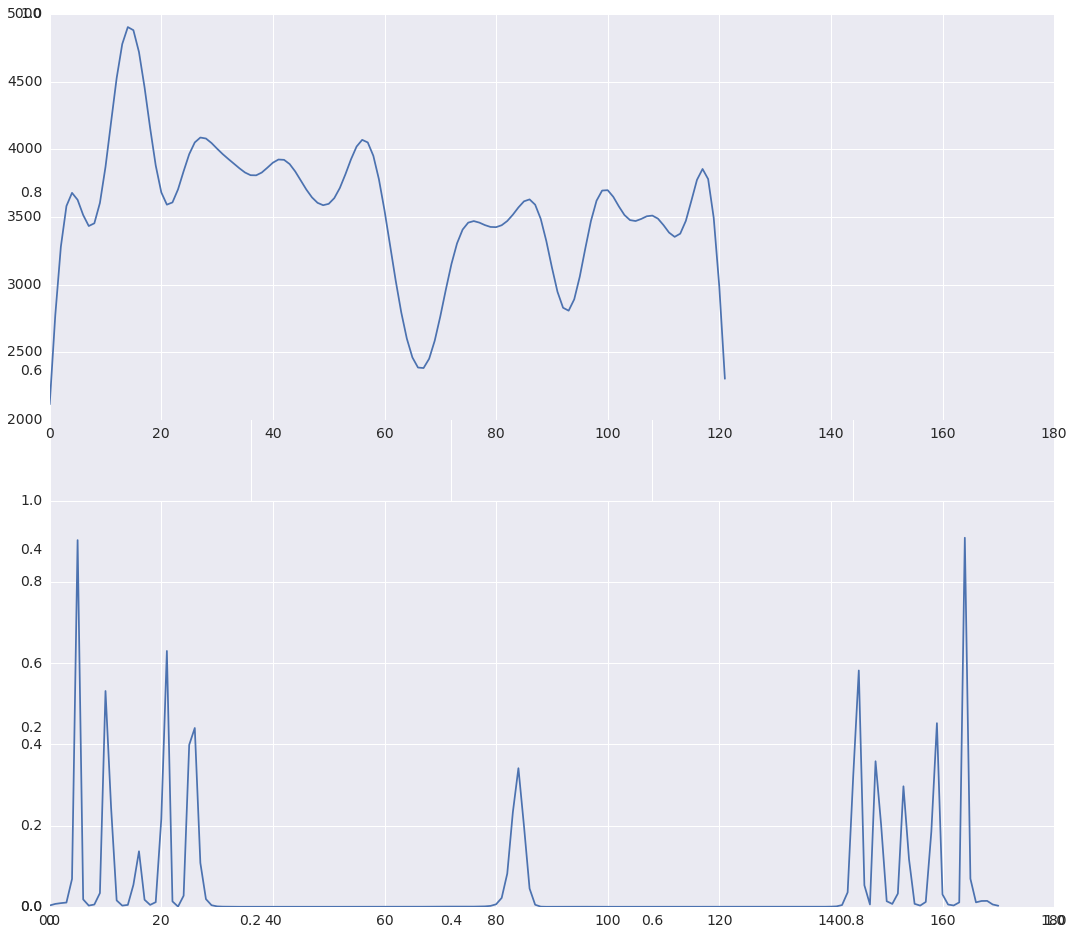

In [91]:
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(2, 1, 1)
ax.plot(s[25:-25])
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp).sum(0))

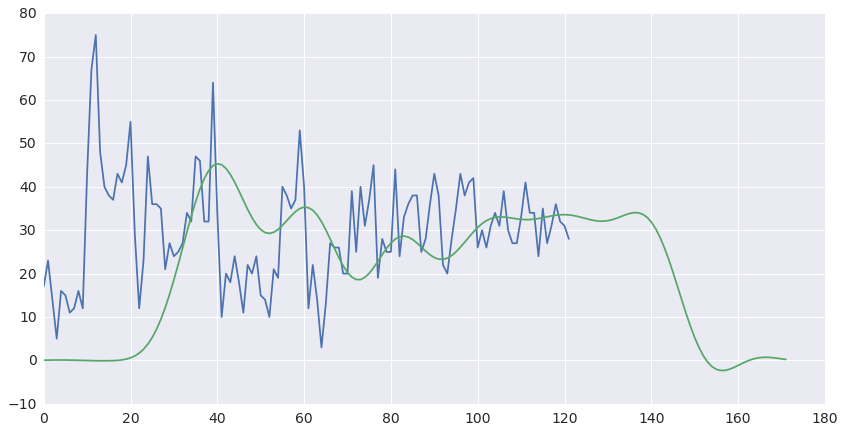

In [97]:
s = np.convolve(df.orders, h)
plt.plot(df.orders)
plt.plot(s[25:-25])

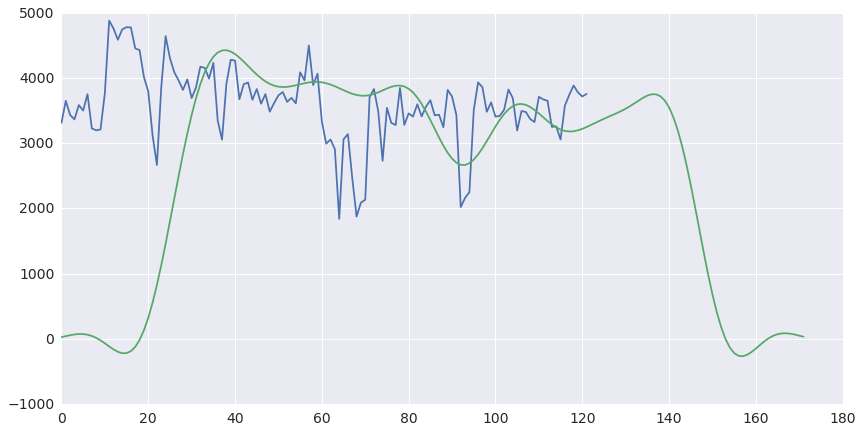

In [98]:
s = np.convolve(df.visits, h)
plt.plot(df.visits)
plt.plot(s[25:-25])

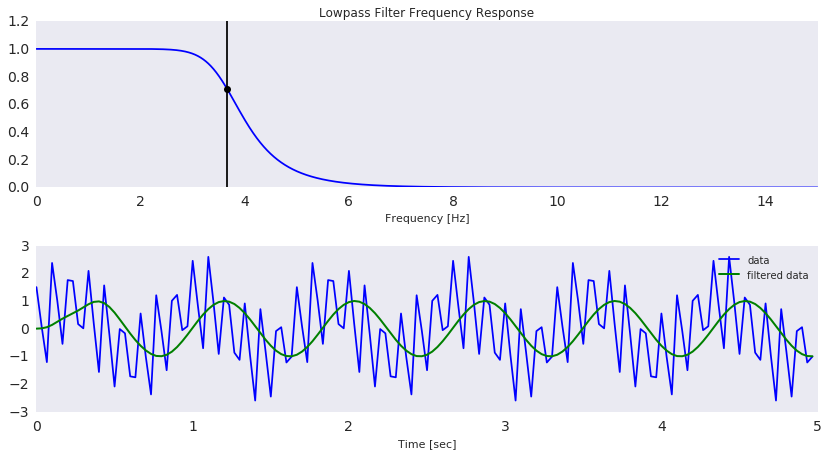

In [68]:



# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

In [2]:
import pymc3 as pm
import theano.tensor as tt

In [3]:
## PyMC

In [6]:
figsize(12.5, 3.5)
# count_data = np.loadtxt("data/txtdata.csv")
# count_data = df.orders
count_data = df.visits
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

NameError: name 'df' is not defined

In [141]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

In [142]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

In [143]:
with model:
#     observation = pm.Poisson("obs", lambda_, observed=count_data)
    observation = pm.Exponential("obs", lambda_, observed=count_data)

In [144]:
### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

100%|██████████| 10000/10000 [00:01<00:00, 5470.32it/s]


In [145]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

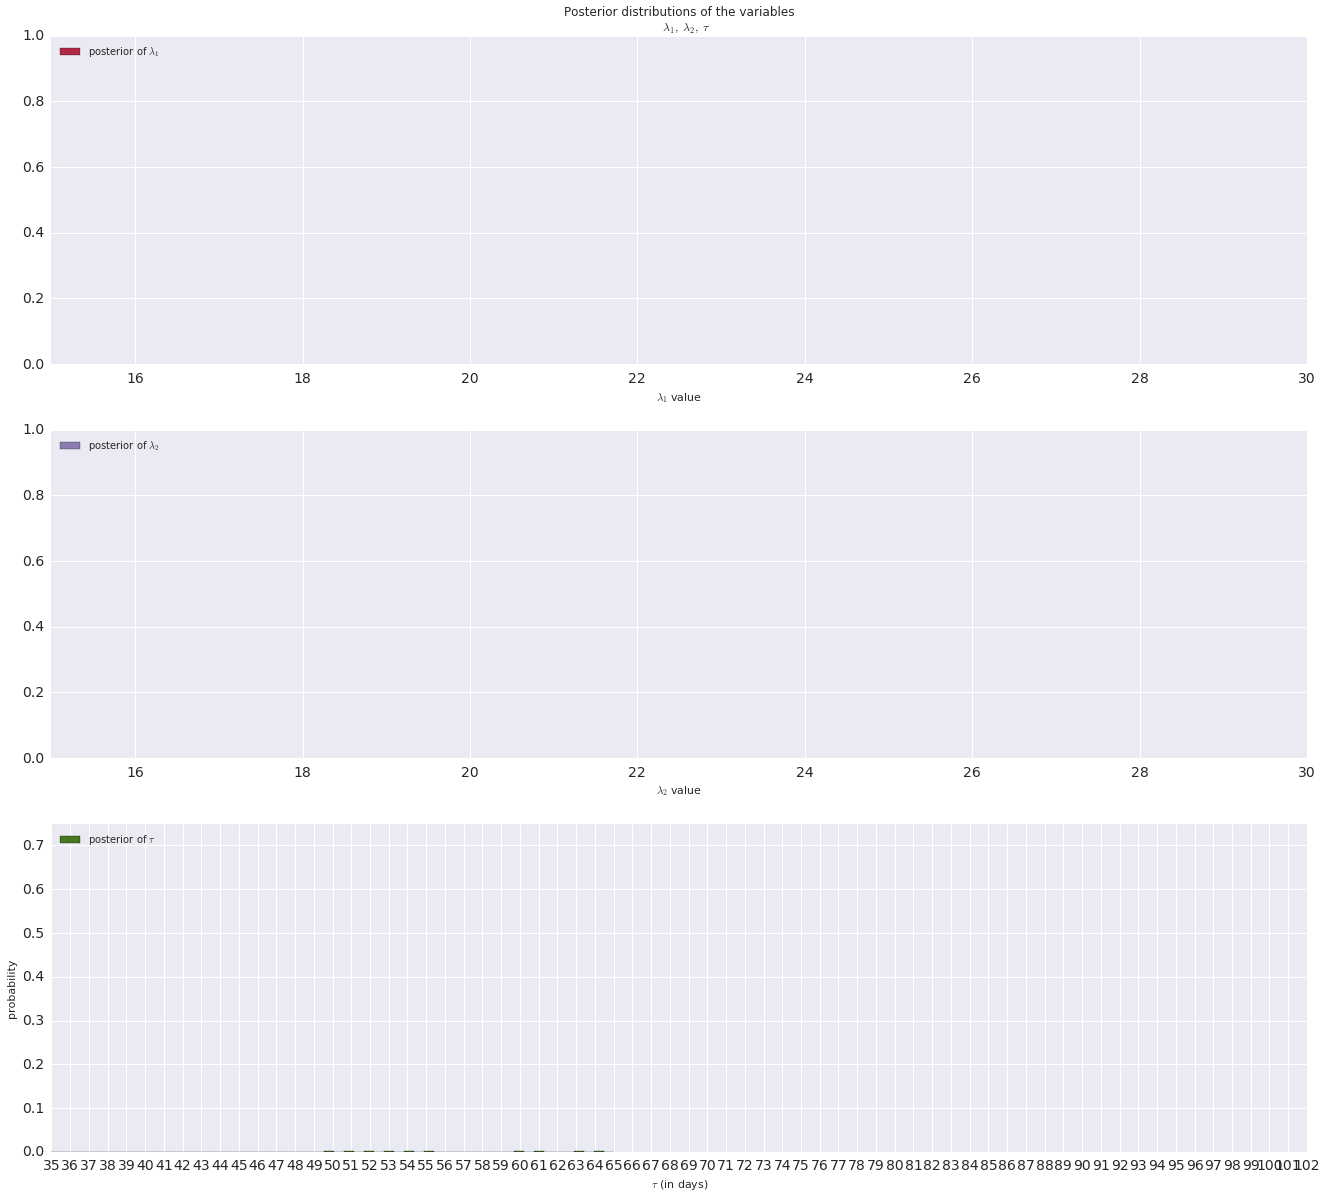

In [146]:
figsize(22.5, 20)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

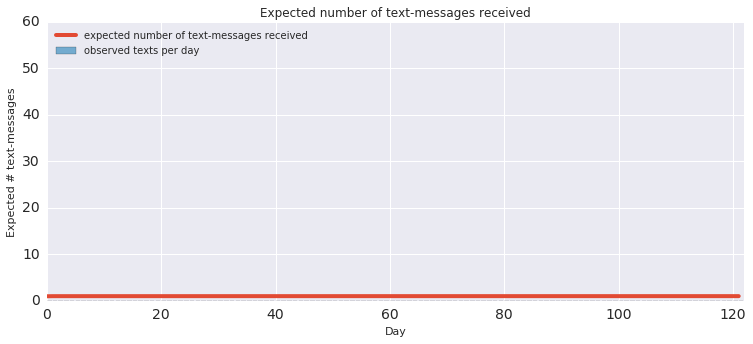

In [147]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");